# Visualisation des anomalies

In [1]:
import pandas as pd
import numpy as np

# Plot et Display
from IPython.display import display
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sb
sb.set()
sb.set_style("darkgrid", {"axes.facecolor": ".9"})

#Lecture des données 
import pickle

In [2]:
#path_test = "../../4A/Projet/Ensemble de test/"
path_test = "../Donnees_projet/Ensemble_de_test/"

In [3]:
with open('liste_propre', 'rb') as fichier:
    mon_depickler = pickle.Unpickler(fichier)
    liste_propre, ind_recupere = mon_depickler.load()

In [4]:
def enlever_pic(serie, seuil=10, pts_moy=2, plot=False) :
    """Retire le pic final, le seuil est le plus petit accroissement considéré comme appartenant
    encore au pic. Les accroissements sont moyennés sur plusieurs points pour ne pas être sensibles 
    aux possibles irrégularités dans le pic.
    L'option plot=True permet de vérifier graphiquement le résultat.
    Retourne la liste tronquée"""
    serie = np.array(serie)
    if plot :
        plt.plot(serie)
        
    accr = abs(serie[1:] - serie[:-1])
    moy_accr = [np.mean(accr[i : i + pts_moy]) for i in range(len(accr) - pts_moy)]

    for ind, val in enumerate(moy_accr[::-1]) :
        if val < seuil and ind >= 1 :
            if plot :
                plt.plot(serie[:-ind], color="red")
                plt.show()
                
            return list(serie[:-ind])
            break
    else : 
        return serie

In [5]:
n = len(liste_propre)
liste_appr = list(np.asarray(liste_propre)[np.asarray(ind_recupere) <= 299])
liste_test = list(np.asarray(liste_propre)[np.asarray(ind_recupere) > 299])
n_appr = len(liste_appr)
n_test = len(liste_test)

In [6]:
anom = [False] * n_test
type_anom = [-1] * n_test
loc = [-1] * n_test

anom[73] = True
type_anom[73] = 1
loc[73] = 200

anom[96] = True
type_anom[96] = 1
loc[96] = 300

anom[36] = True
type_anom[36] = 1
loc[36] = 400

anom[32] = True
type_anom[32] = 1
loc[32] = 300

anom[33] = True
type_anom[33] = 1
loc[33] = 200

anom[107] = True
type_anom[107] = 2
loc[107] = 600

anom[60] = True
type_anom[60] = 2
loc[60] = 400

anom[113] = True
type_anom[113] = 2
loc[113] = 400

anom[9] = True
type_anom[9] = 2
loc[9] = 200

anom[11] = True
type_anom[11] = 2
loc[11] = 300

anom[53] = True
type_anom[53] = 3
loc[53] = 400

anom[114] = True
type_anom[114] = 3
loc[114] = 400

anom[14] = True
type_anom[14] = 3
loc[14] = 500

anom[79] = True
type_anom[79] = 3
loc[79] = 400

anom[29] = True
type_anom[29] = 3
loc[29] = 300

anom[27] = True
type_anom[27] = 4
loc[27] = 300

anom[121] = True
type_anom[121] = 4
loc[121] = 300

anom[5] = True
type_anom[5] = 4
loc[5] = 400

anom[89] = True
type_anom[89] = 4
loc[89] = 200

anom[99] = True
type_anom[99] = 4
loc[99] = 100  

anom = [False] * n_appr + anom
type_anom = [-1] * n_appr + type_anom
loc = [-1] * n_appr + loc

In [126]:
np.where(np.asarray(anom))[0] # Indices des anomalies

array([302, 306, 308, 311, 324, 326, 329, 330, 333, 350, 357, 370, 376,
       386, 393, 396, 404, 410, 411, 418])

In [117]:
def df_fenetres(liste_comp, N, anom, loc):
    serie = []
    #origine = []
    ind_debut = []
    valeurs = []
    anom_fen = []
    for i, val, loc_i in zip(ind_recupere, liste_comp, loc):
        # Liste des fenêtres de l'enregistrement
        fenetres = [val[i * N:(i + 1) * N] for i in range((len(val) + N - 1) // N ) if len(val[i * N:(i + 1) * N]) == N]
        nb_fen = len(fenetres)
        valeurs += fenetres
        anom_fen_i = [False] * nb_fen
        pos_anom_deb_fen = loc_i // N
        pos_anom_fin_fen = (loc_i + 55) // N
        if loc_i > -1:
            try:
                for pos in range(pos_anom_deb_fen, pos_anom_fin_fen + 1):
                    anom_fen_i[pos] = True

            except:
                pass
        anom_fen += anom_fen_i
        ind_debut += list(range(0, nb_fen * N, N))
        serie += [i] * nb_fen
        """if i < 300:
            origine += ["appr"] * nb_fen
        else:
            origine += ["test"] * nb_fen"""
        
    
    df = pd.DataFrame(data={"id" : list(range(len(serie))), "serie" : serie, "ind_debut" : ind_debut, "valeurs" : valeurs, "anom" : anom_fen})
        
    return df.set_index(["id"])

In [118]:
N = 100
data_fenetres = df_fenetres(liste_propre, N, anom, loc)

In [127]:
data_ajout_anom = data_fenetres[data_fenetres["anom"]]
offset = 10 ** (int(np.log10(data_fenetres.index.values[-1])) + 1)

# Il faut prendre l'intégralité de la liste pour 
# il faut recopier toutes les séries dans lesquelles il y a une anomalie et pas juste les fenetres

for i in range(1,5):
    data_ajout_anom.index += offset
    df_supervise= pd.concat([data_fenetres, data_ajout_anom])
    
#df supervise contient les données d'apprentissage + les données de tests + les séries anormales recopiées 4 fois
# les séries recopiées ont pour indice leur indice de départ + k*1000 pour k=1,..,4
df_supervise.tail(50)

,serie,ind_debut,valeurs,anom
id,,,,
2748,423,0,"[1424.0, 1432.0, 1424.0, 1424.0, 1424.0, 1416....",False
2749,423,100,"[1616.0, 1624.0, 1624.0, 1624.0, 1624.0, 1632....",False
2750,423,200,"[1744.0, 1752.0, 1752.0, 1744.0, 1744.0, 1752....",False
2751,423,300,"[1728.0, 1728.0, 1728.0, 1736.0, 1736.0, 1736....",False
2752,423,400,"[1720.0, 1720.0, 1712.0, 1712.0, 1704.0, 1712....",False
2753,424,0,"[1384.0, 1384.0, 1392.0, 1392.0, 1400.0, 1400....",False
2754,424,100,"[1384.0, 1384.0, 1376.0, 1400.0, 1440.0, 1480....",False
2755,424,200,"[1616.0, 1616.0, 1608.0, 1616.0, 1616.0, 1616....",False
2756,424,300,"[1600.0, 1600.0, 1600.0, 1600.0, 1600.0, 1600....",False


In [33]:
def plot_anom_type(Type):
    for num in df_supervise.index.values:
        TS = df_supervise.loc[num]
        loc = TS["loc"]
        serie = TS["valeurs"]

        if TS["type"] == Type: 
            fig, ax = plt.subplots(figsize=(12, 7))
            plt.title("Série numéro " + str(num) + ", type " + str(Type), size=20, color='r', fontweight='bold')

            ax.plot(range(loc), serie[: loc], 'b')
            ax.plot(range(loc - 1, loc + 56), serie[loc - 1 : loc + 56], 'r')
            ax.plot(range(loc + 55, len(serie)), serie[loc + 55 :], 'b')

        plt.show()

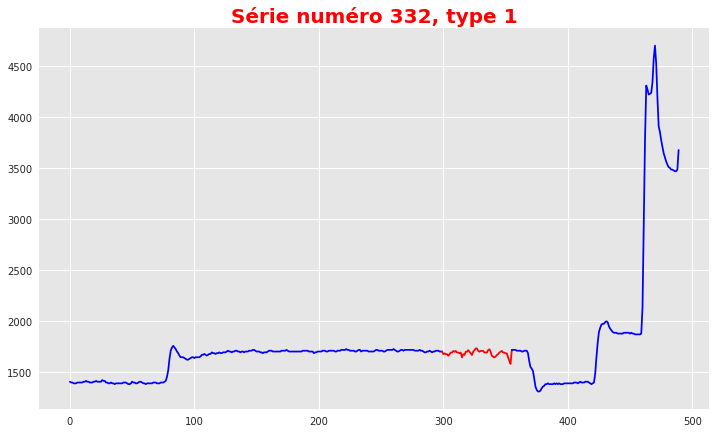

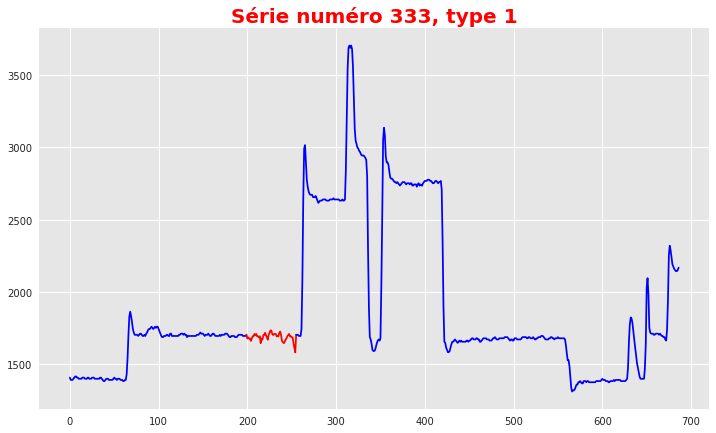

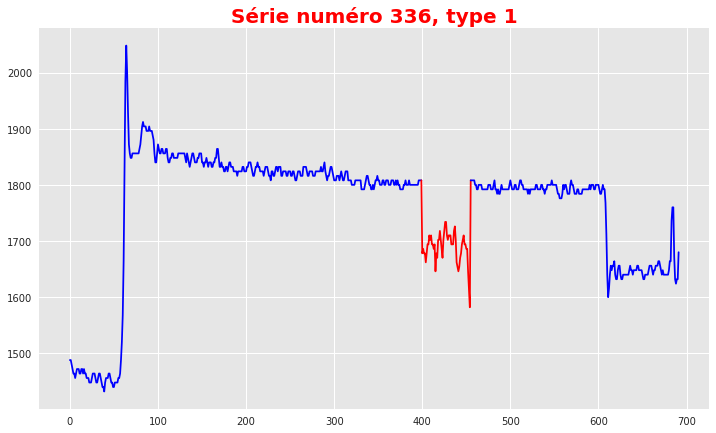

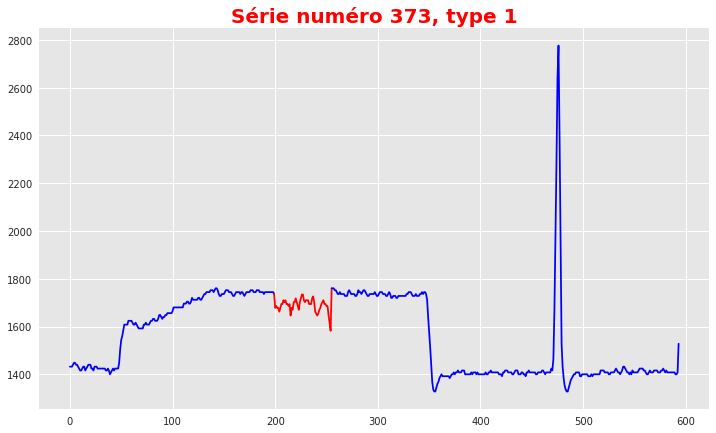

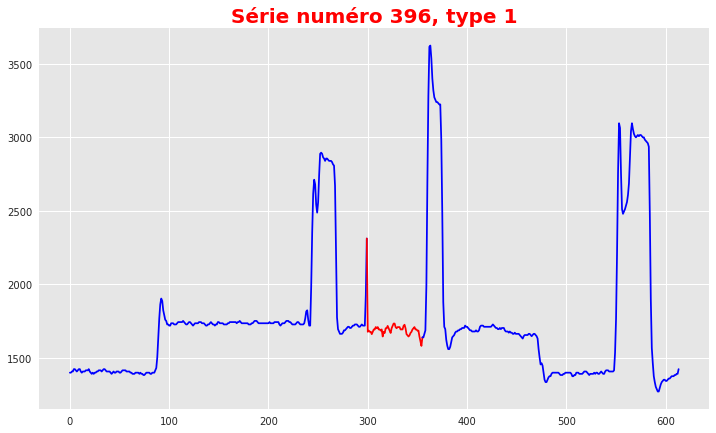

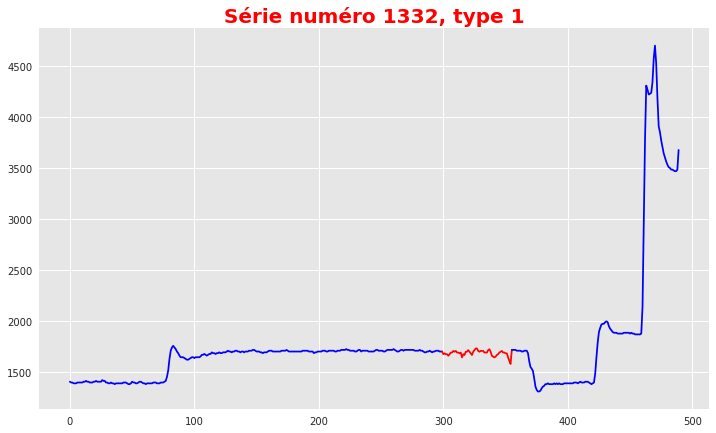

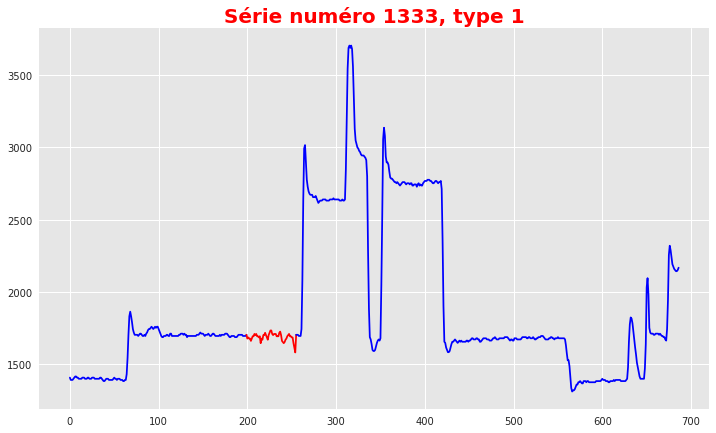

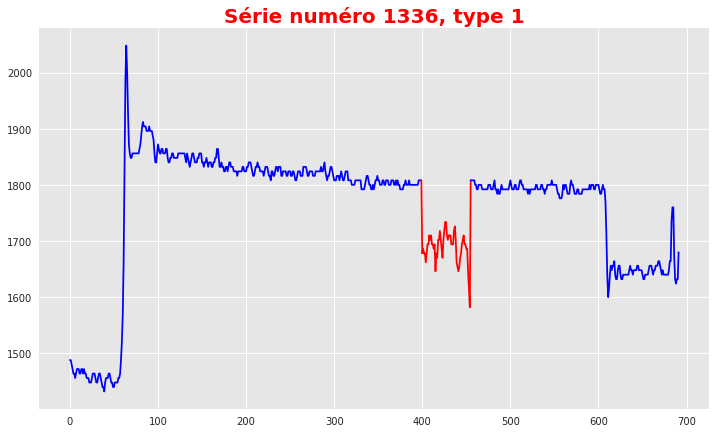

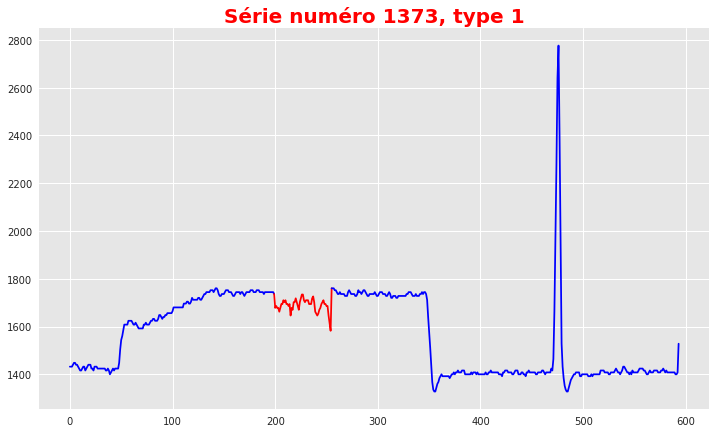

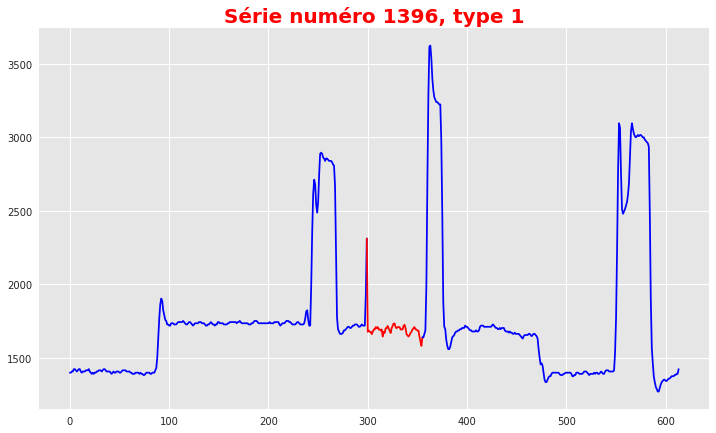

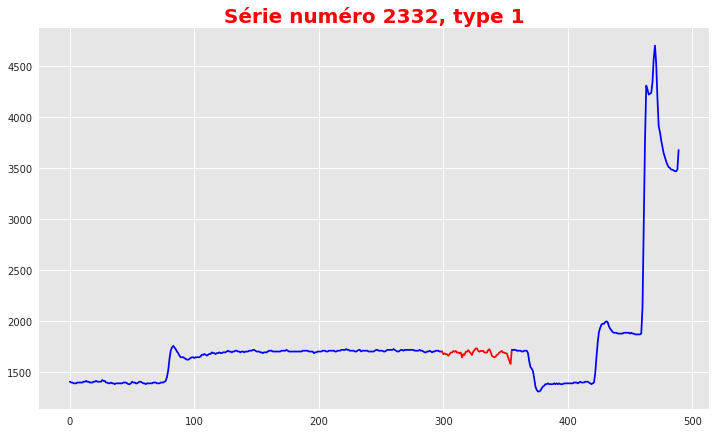

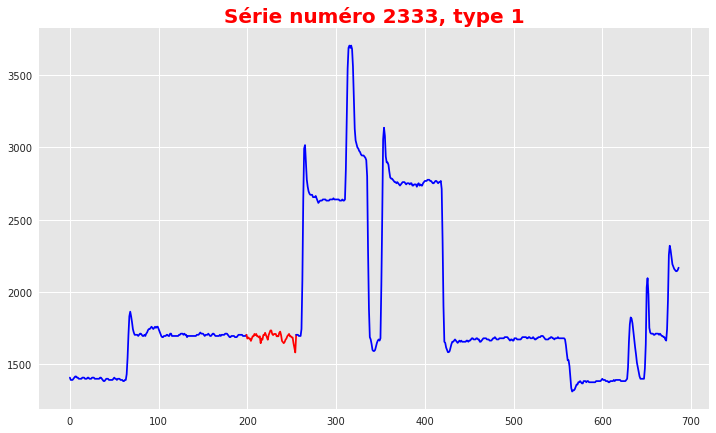

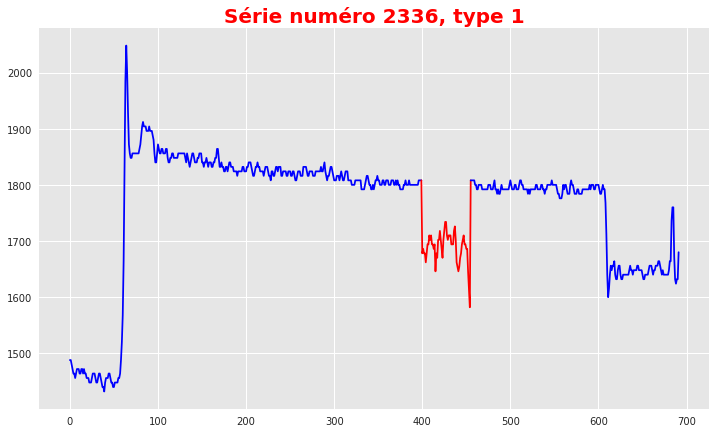

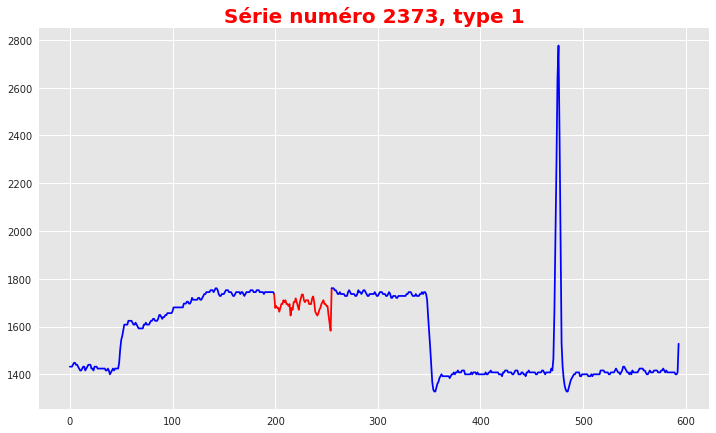

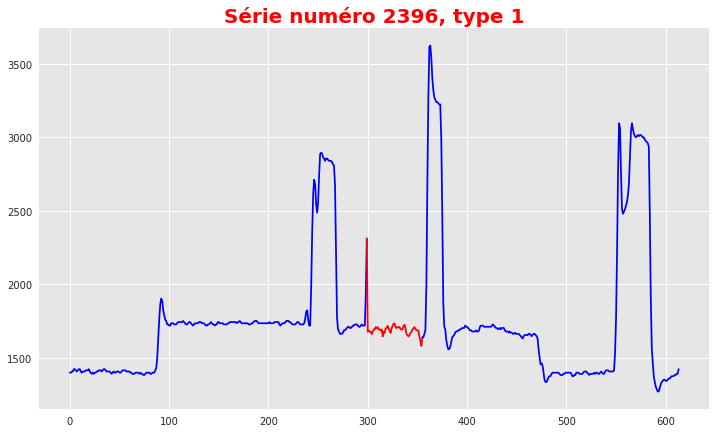

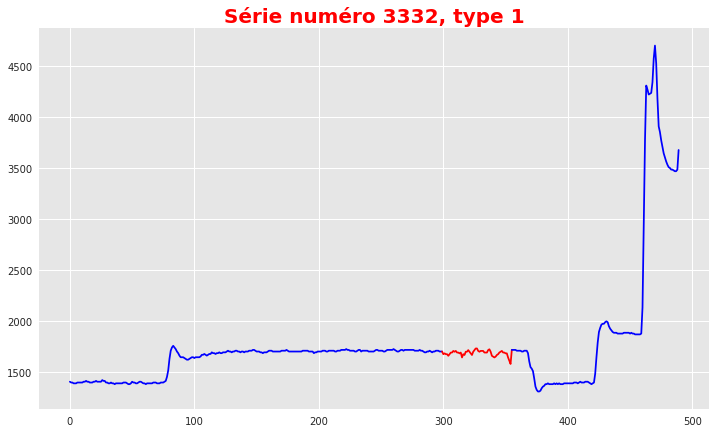

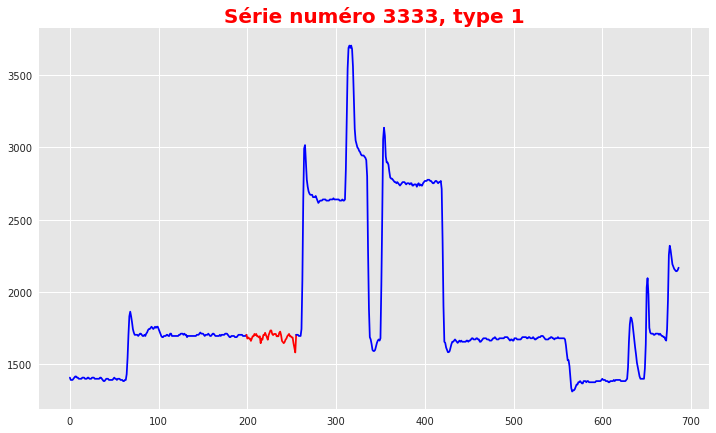

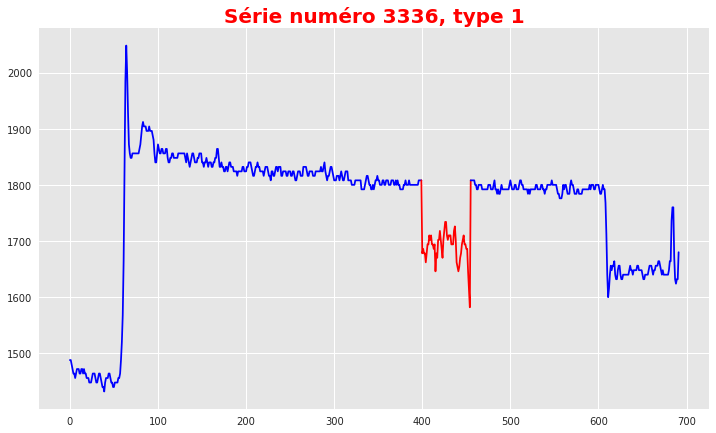

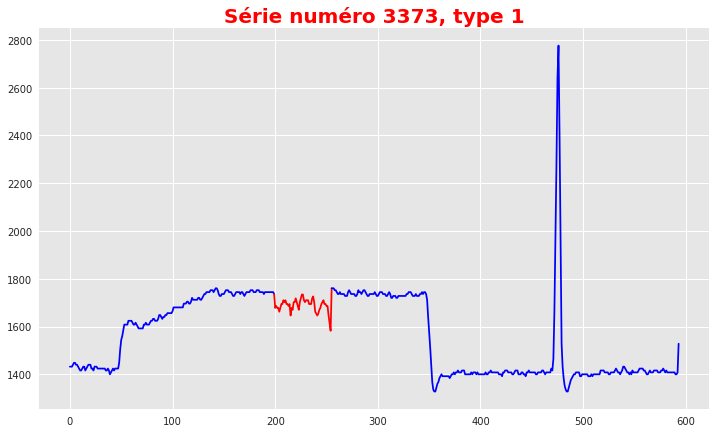

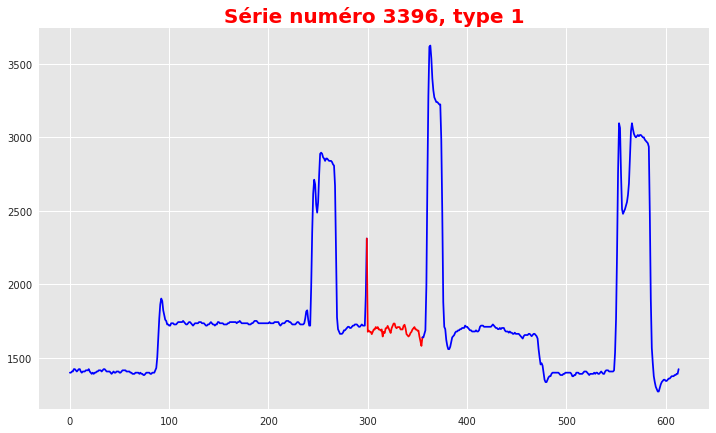

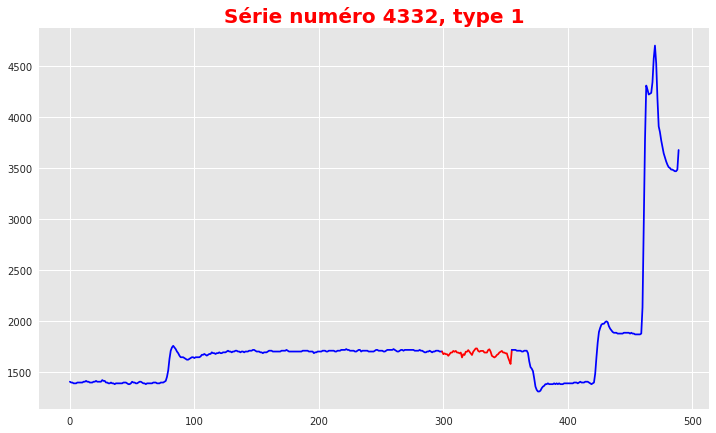

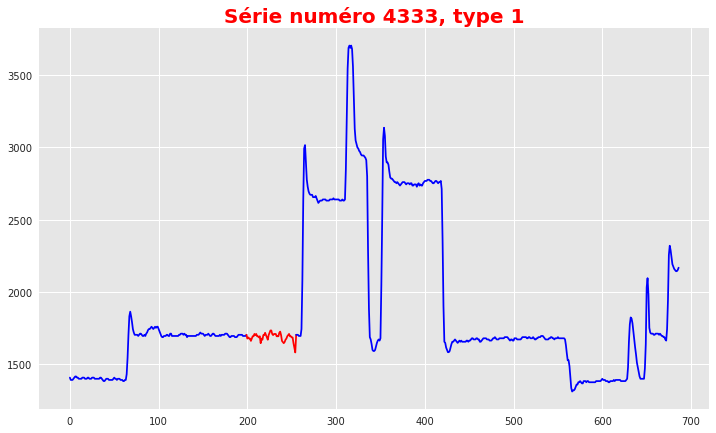

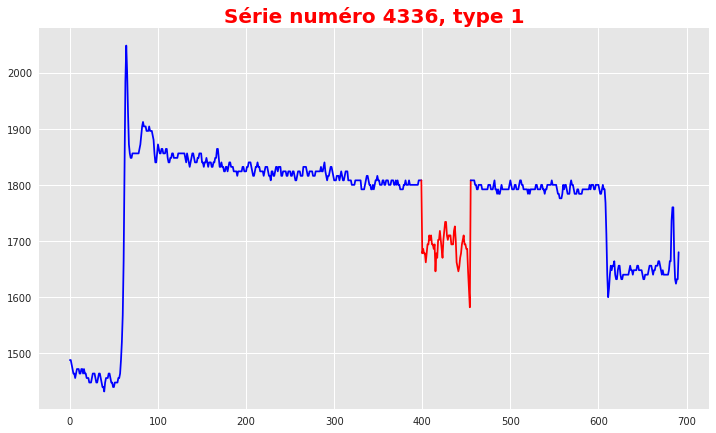

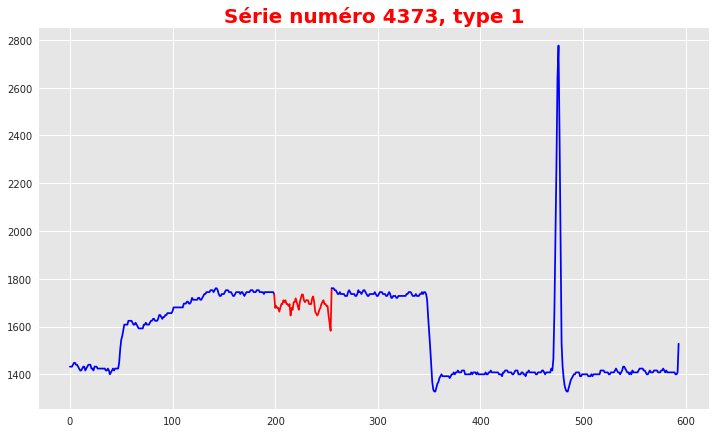

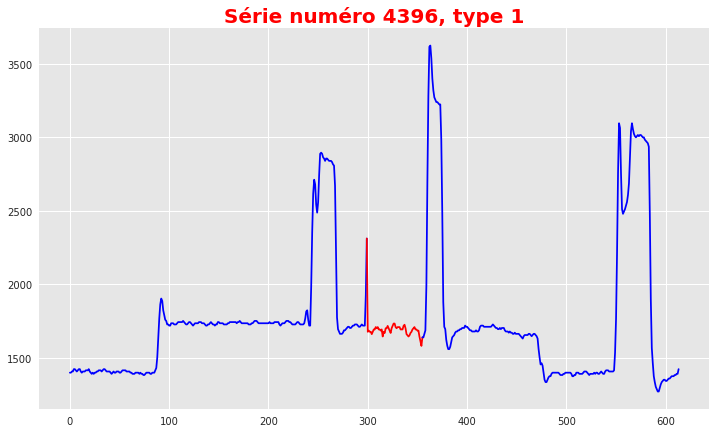

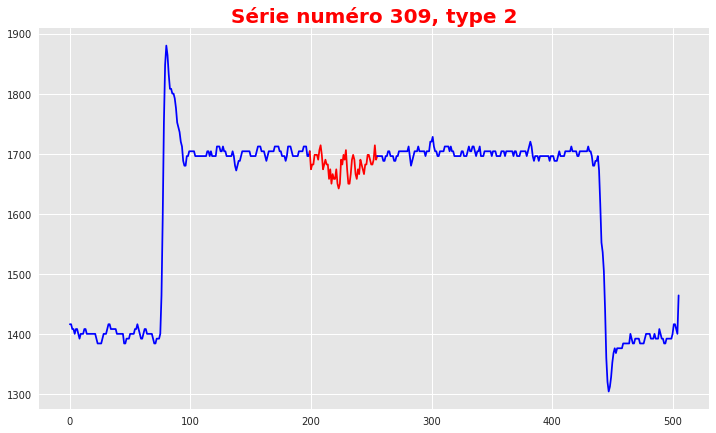

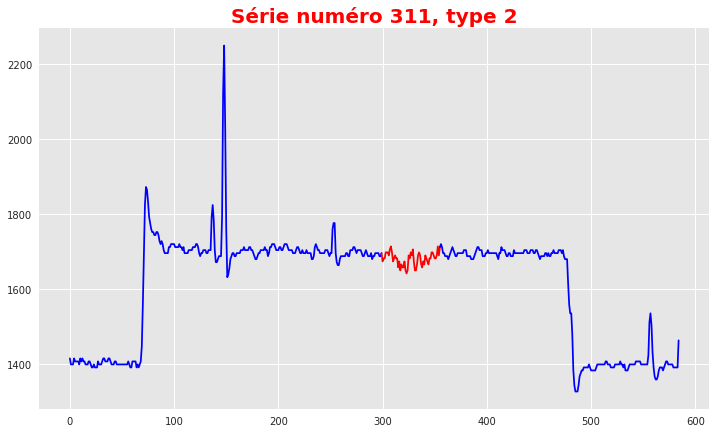

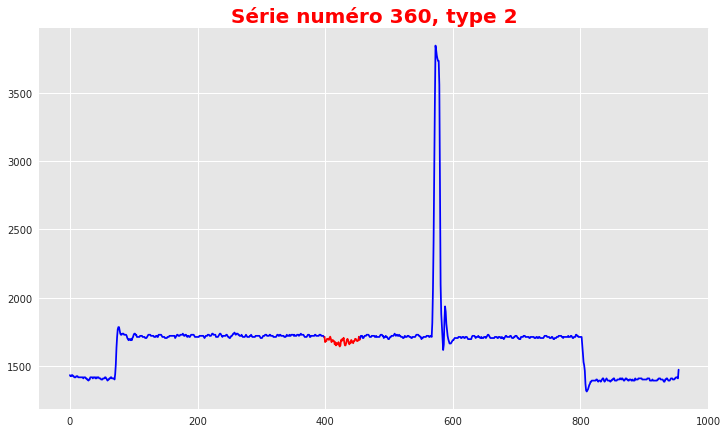

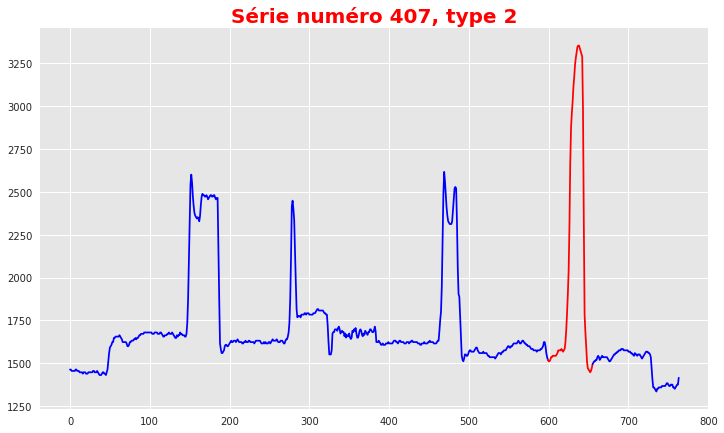

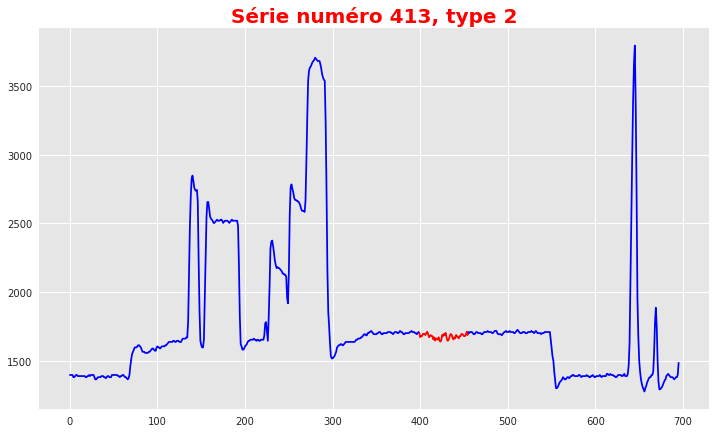

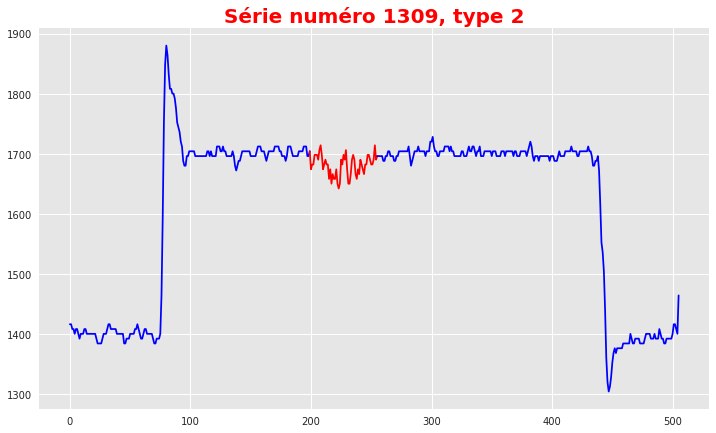

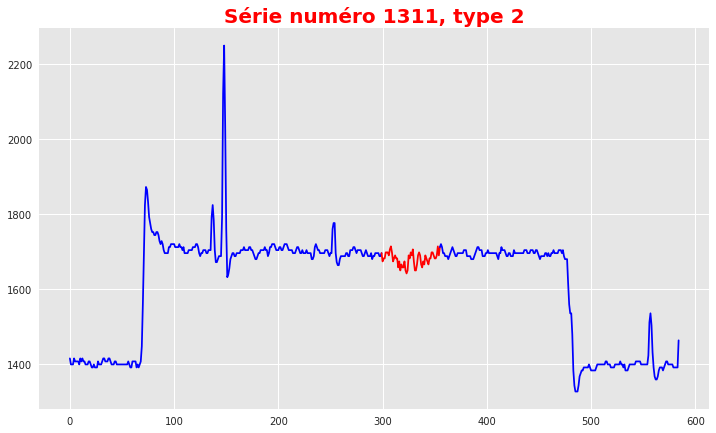

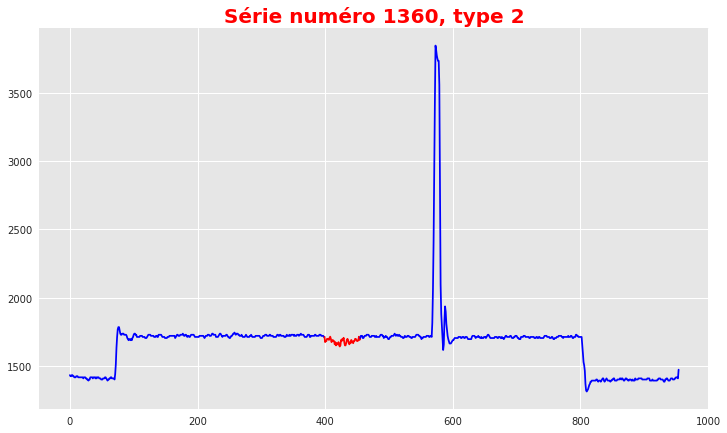

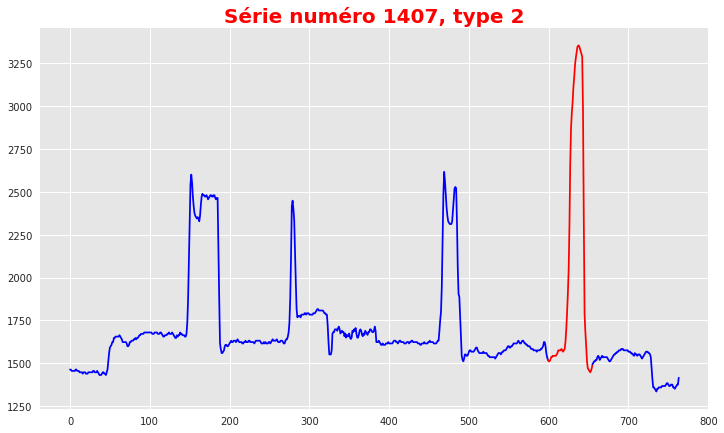

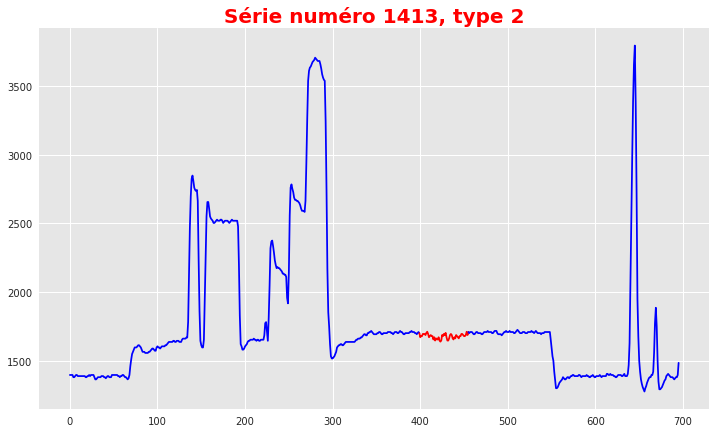

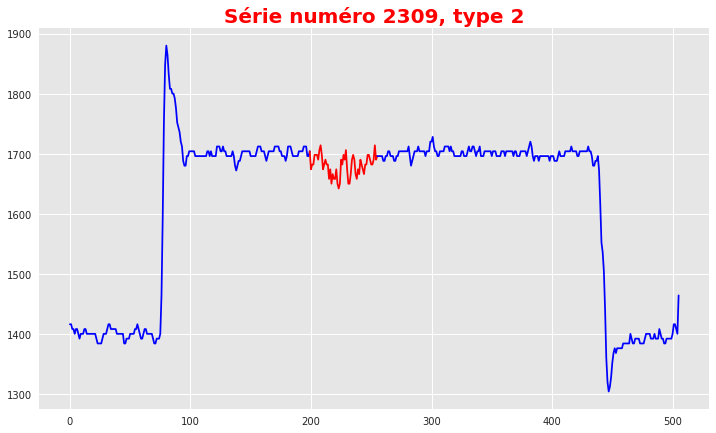

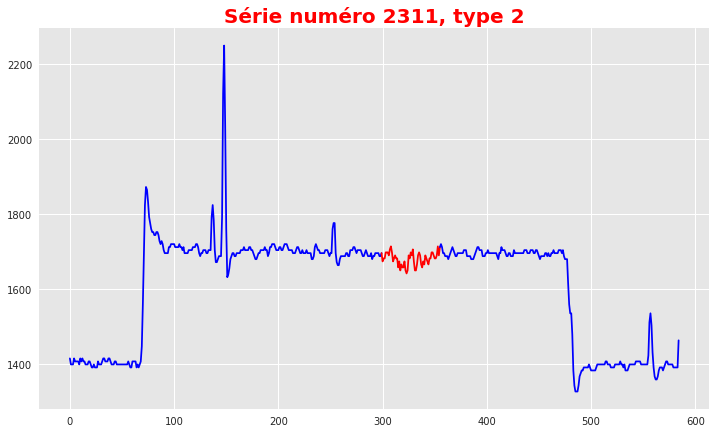

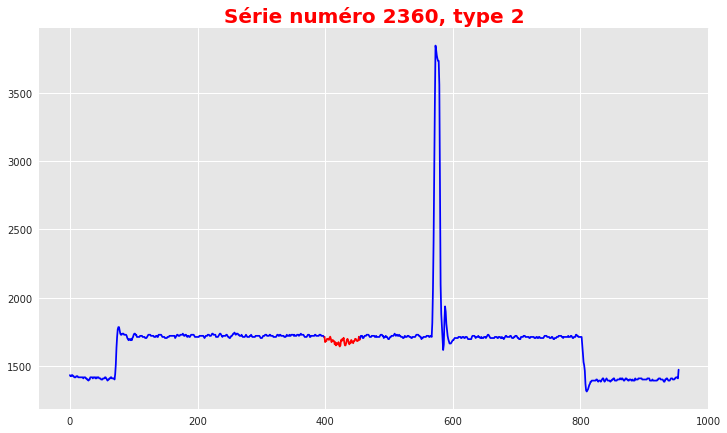

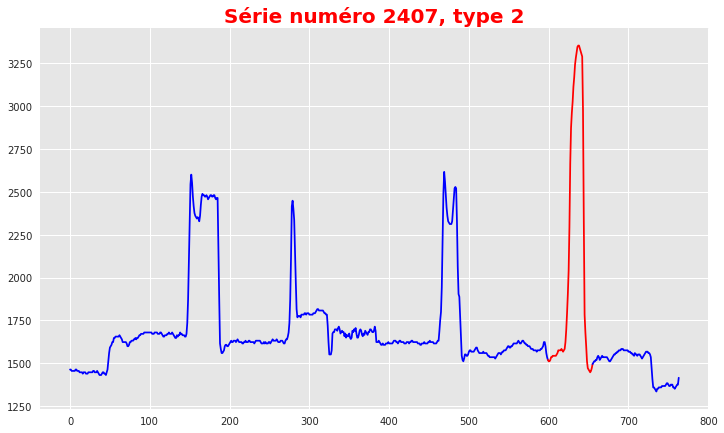

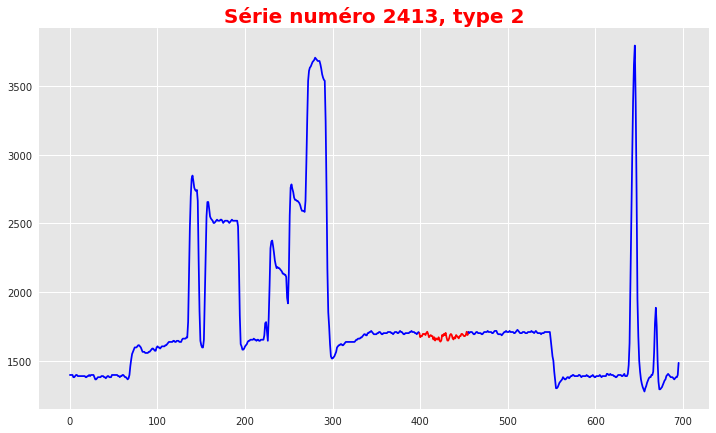

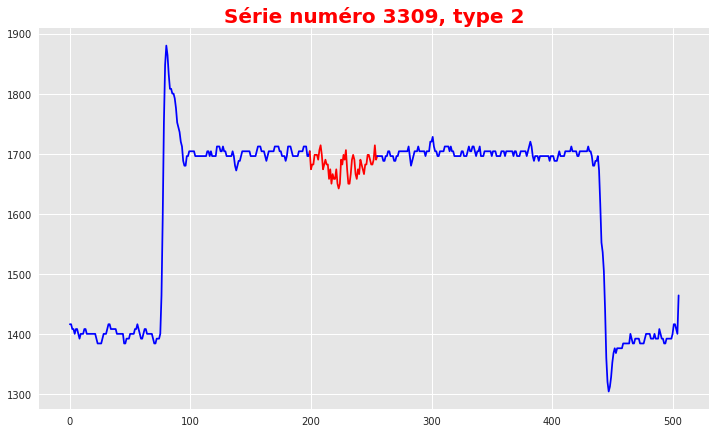

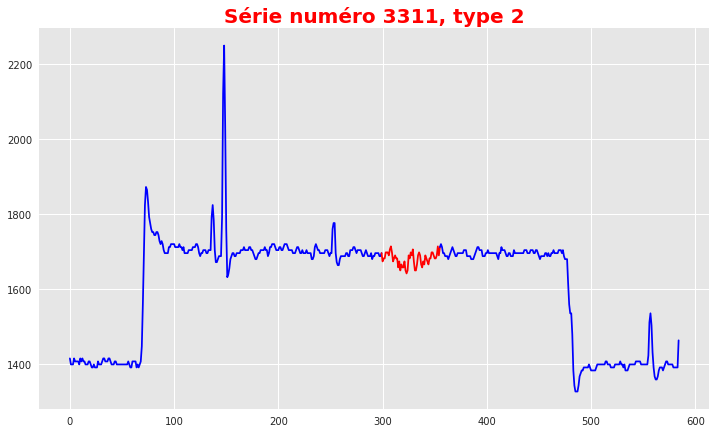

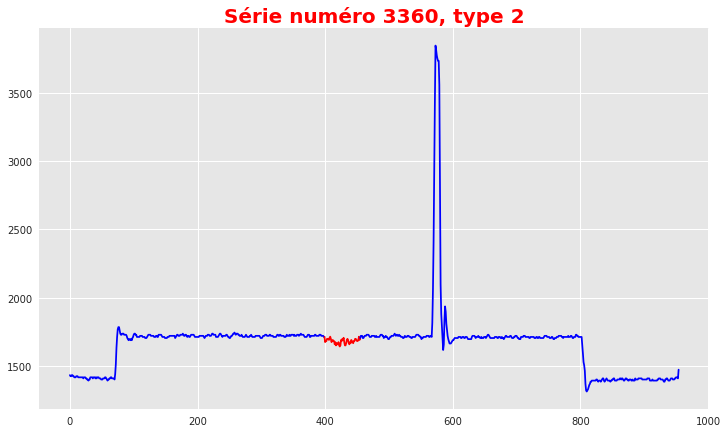

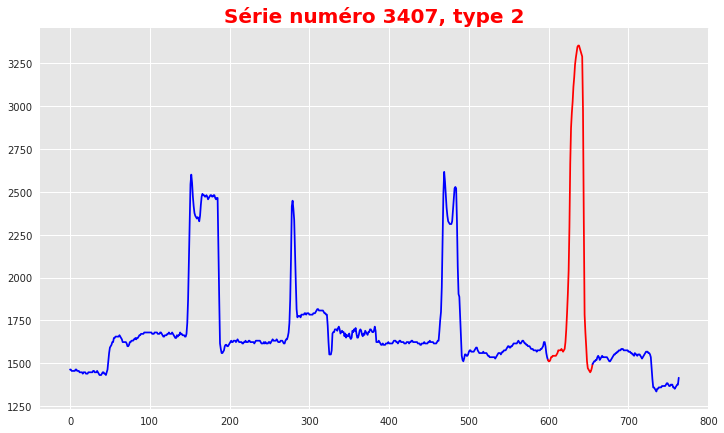

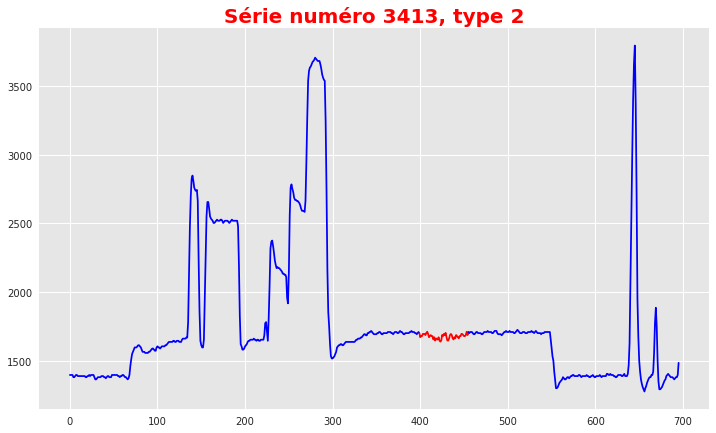

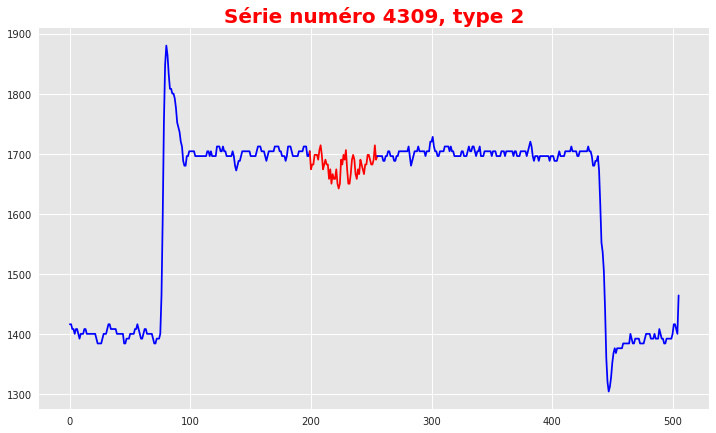

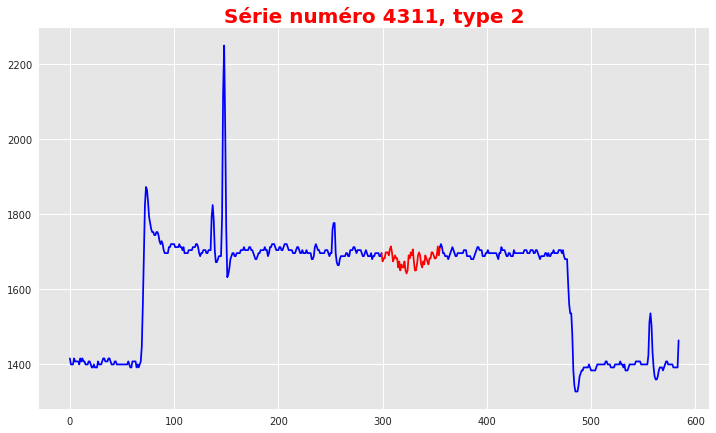

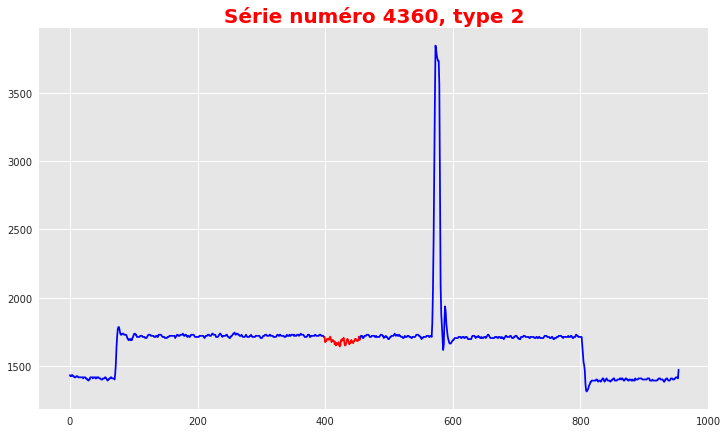

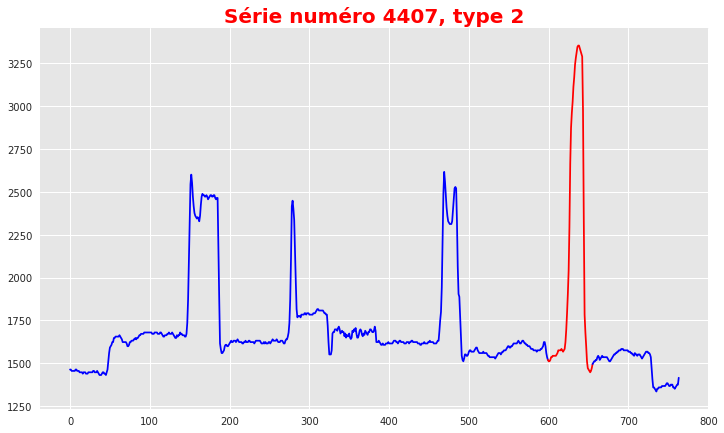

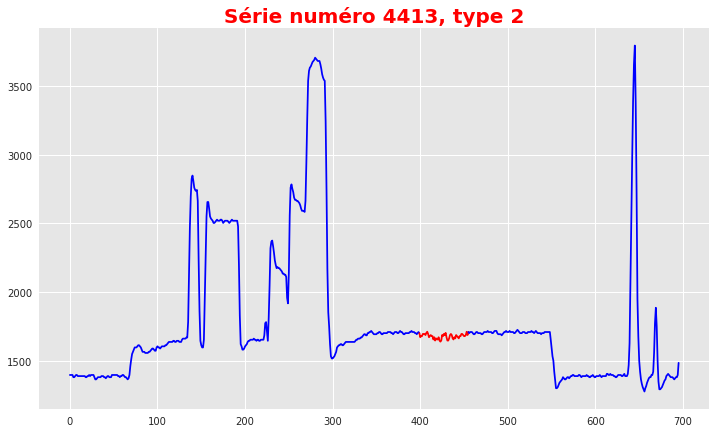

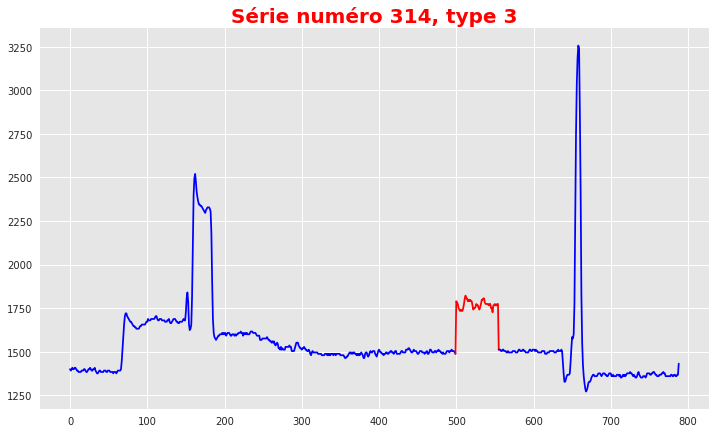

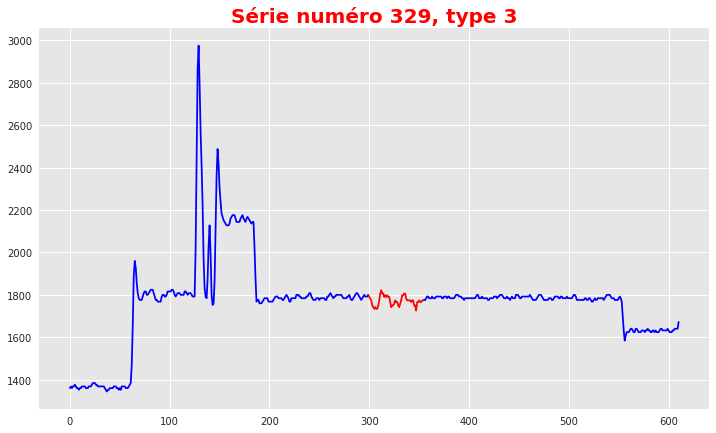

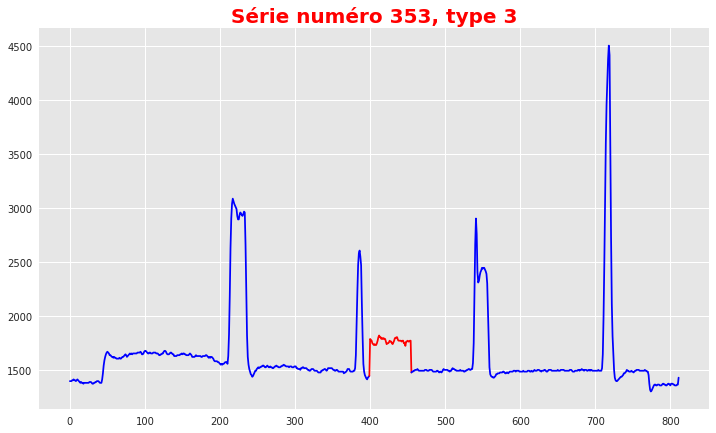

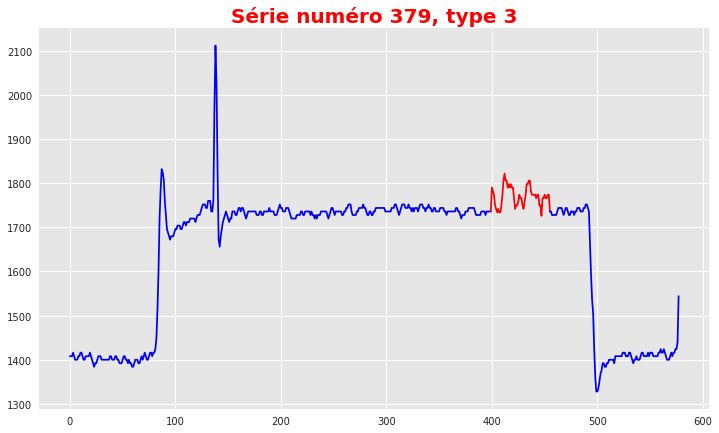

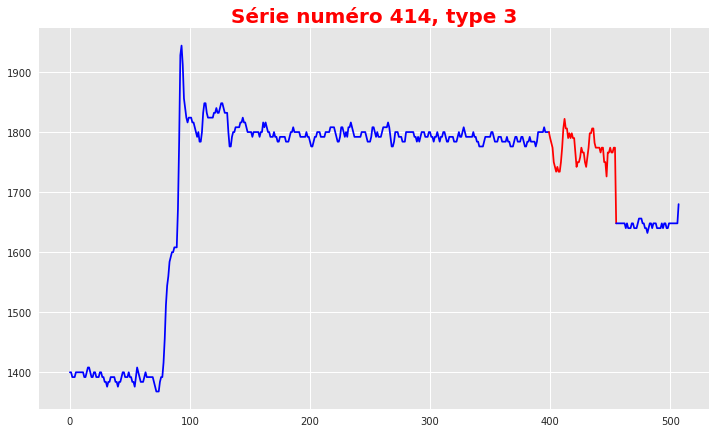

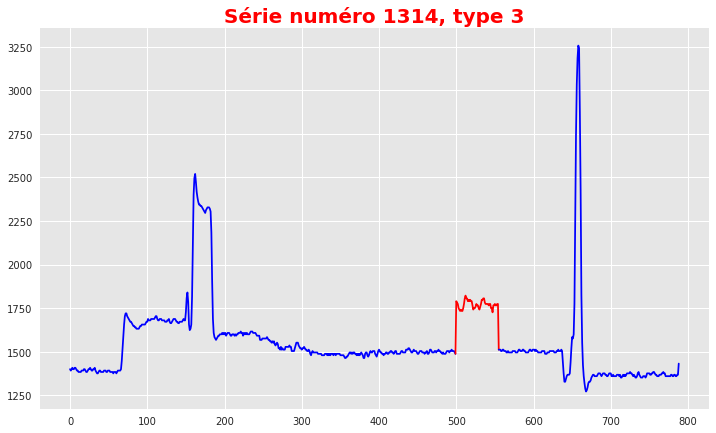

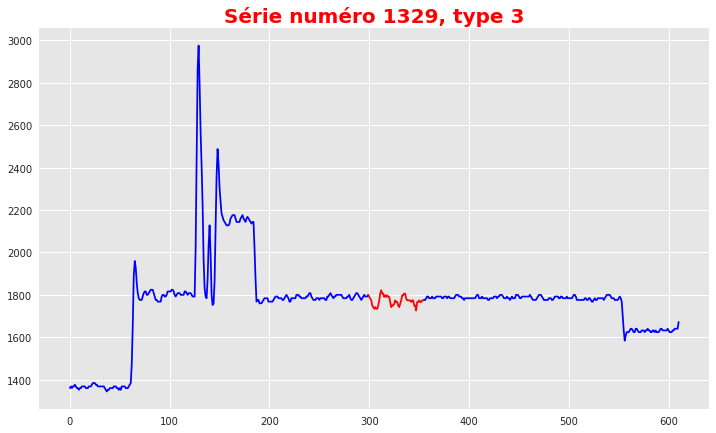

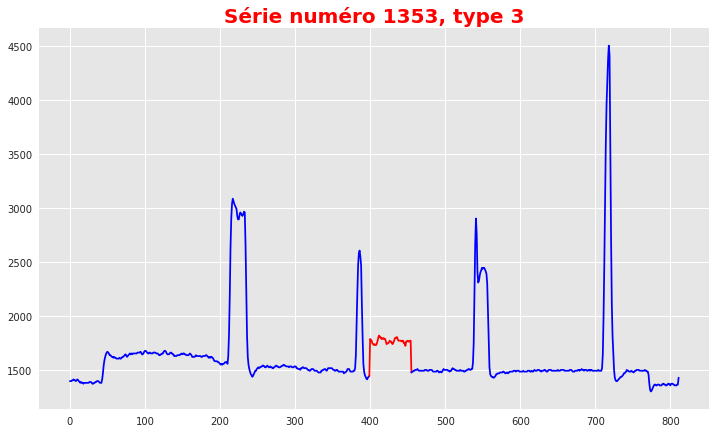

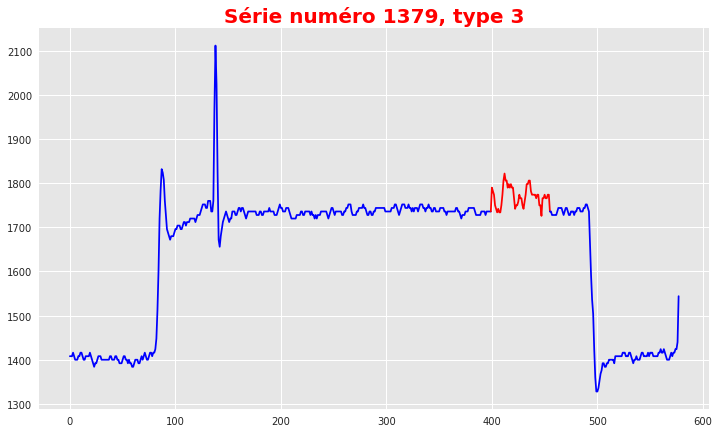

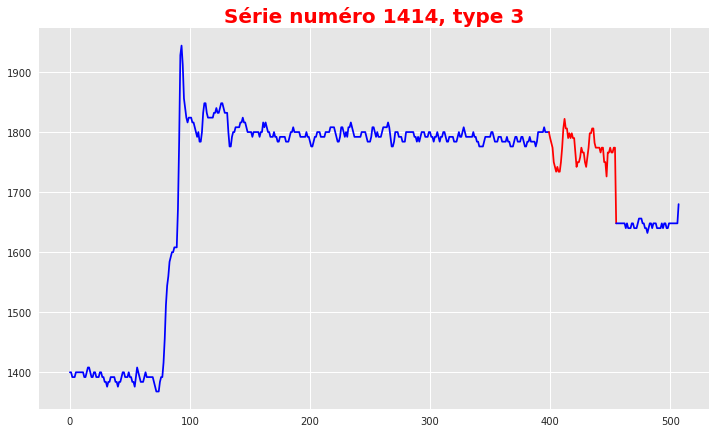

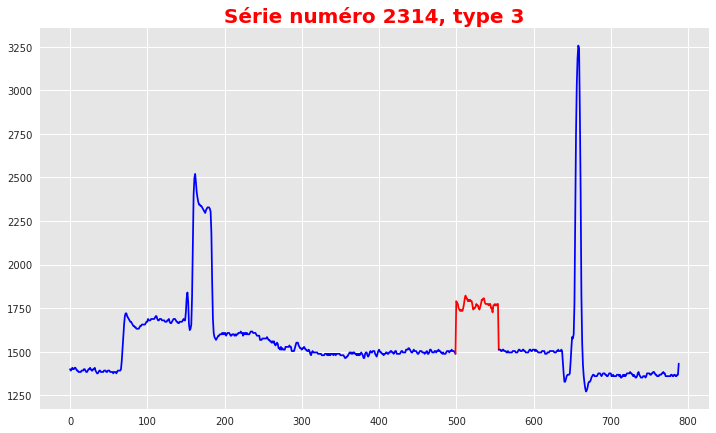

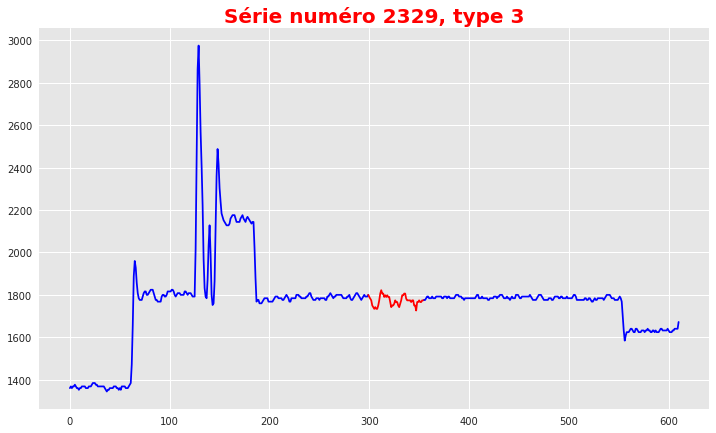

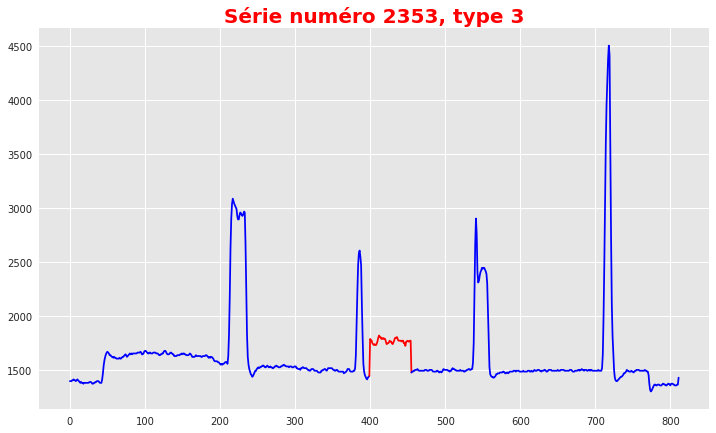

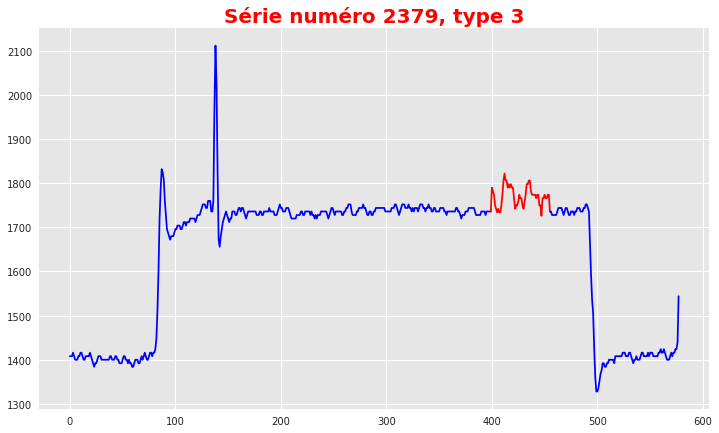

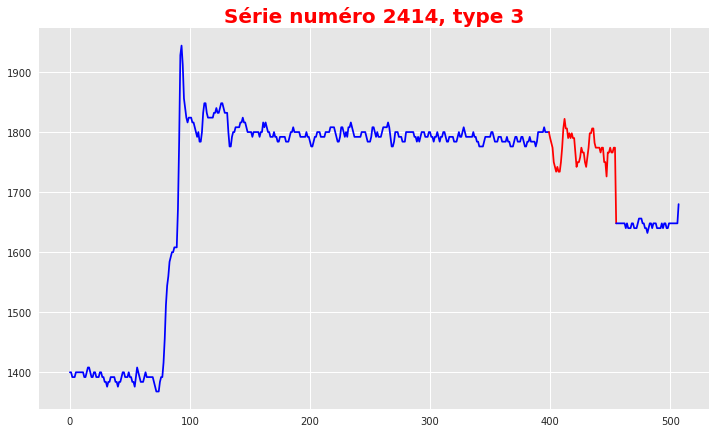

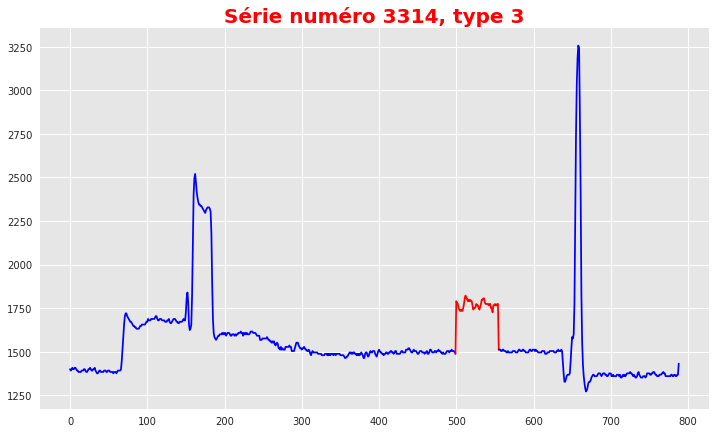

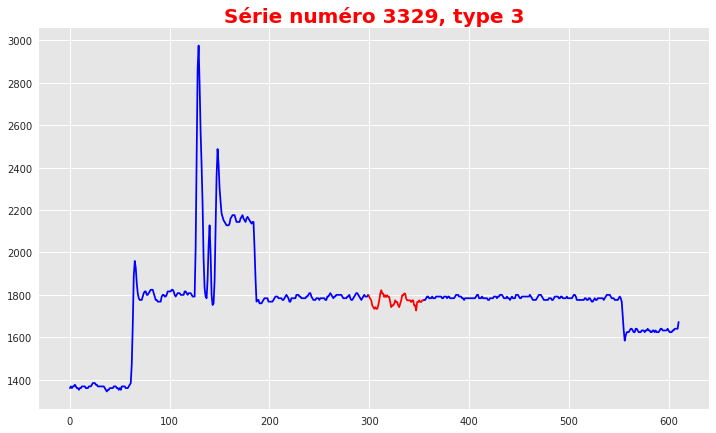

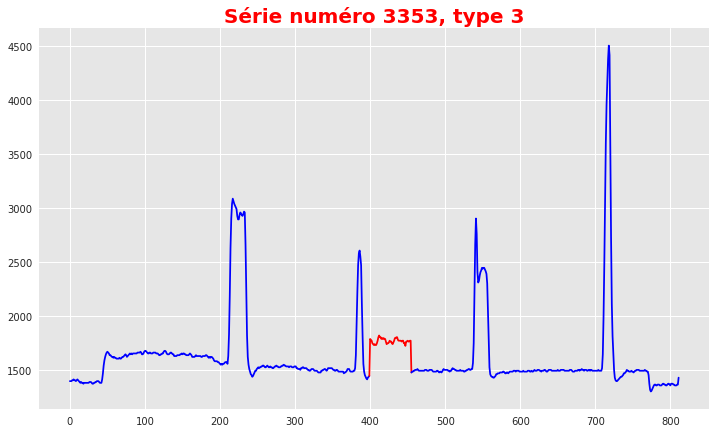

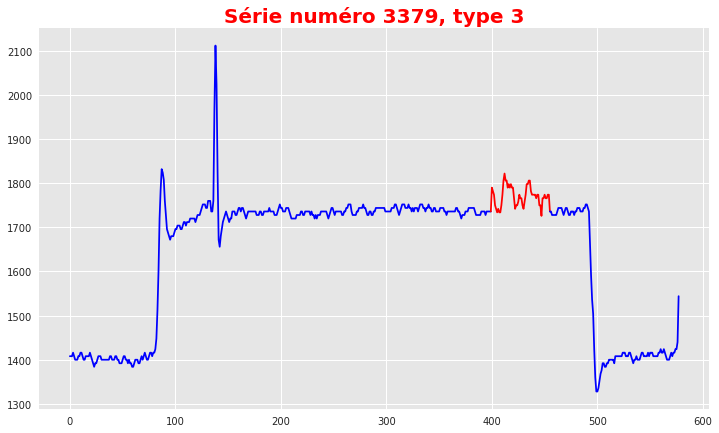

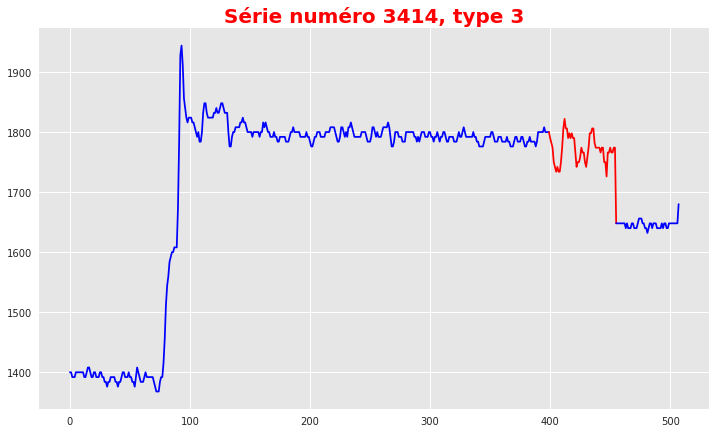

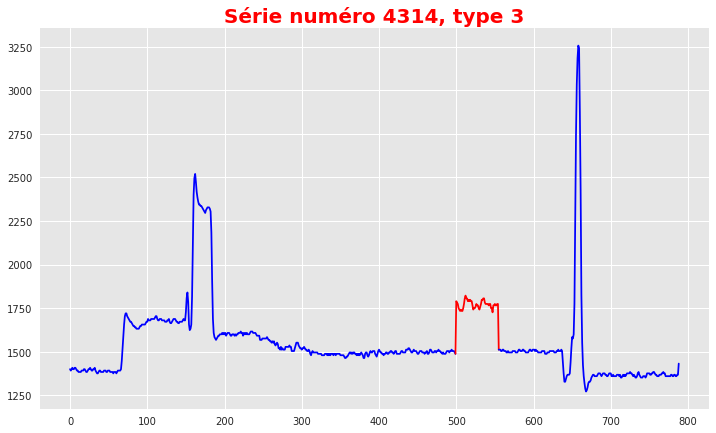

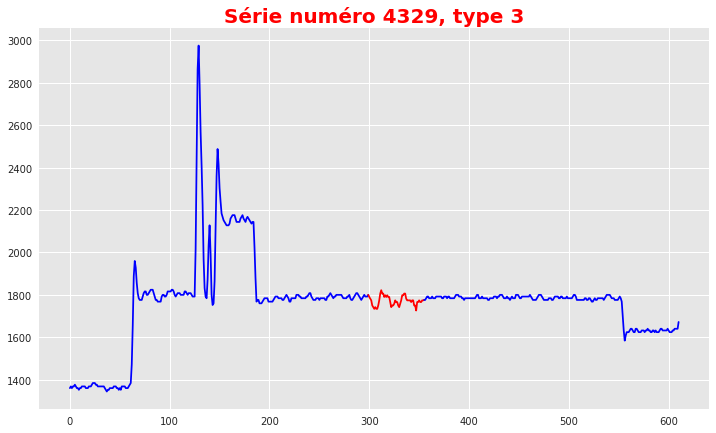

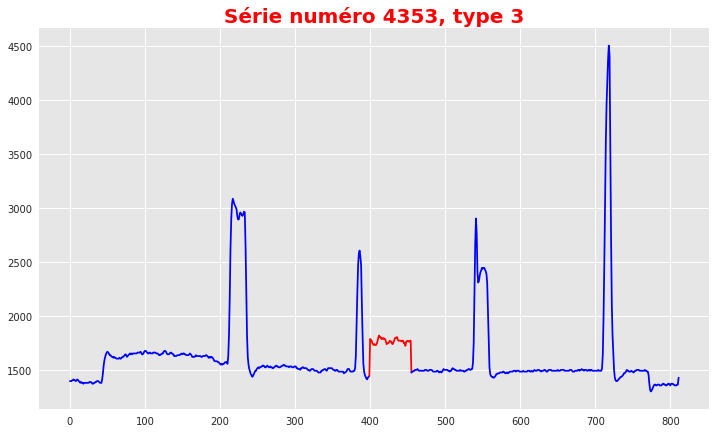

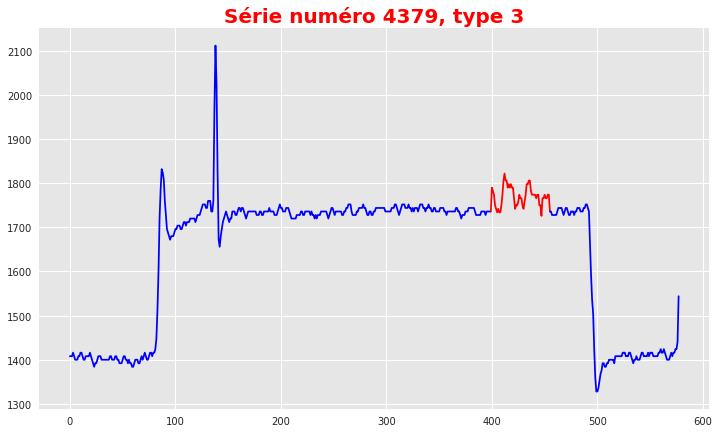

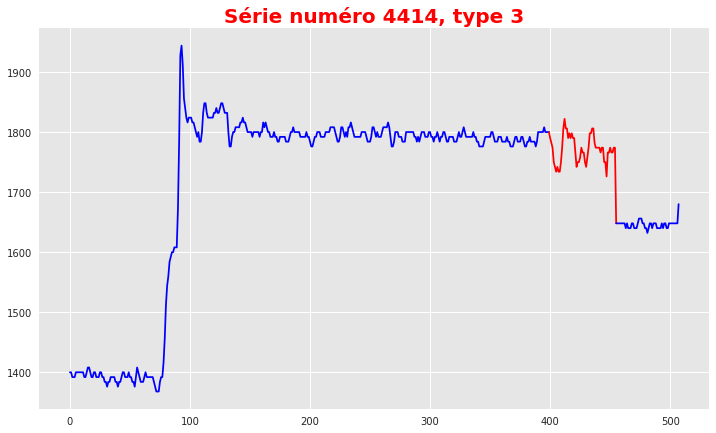

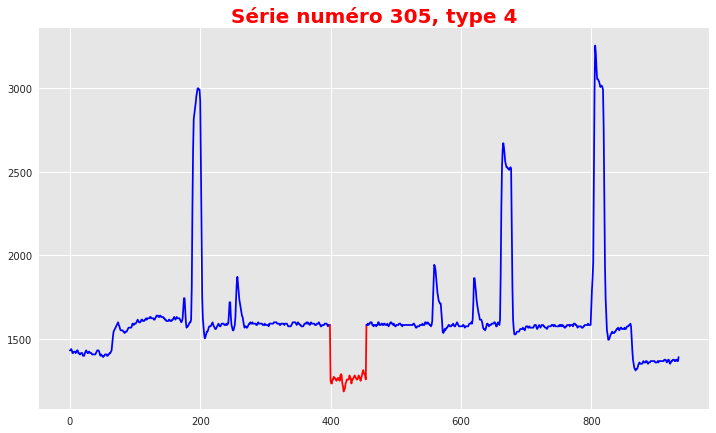

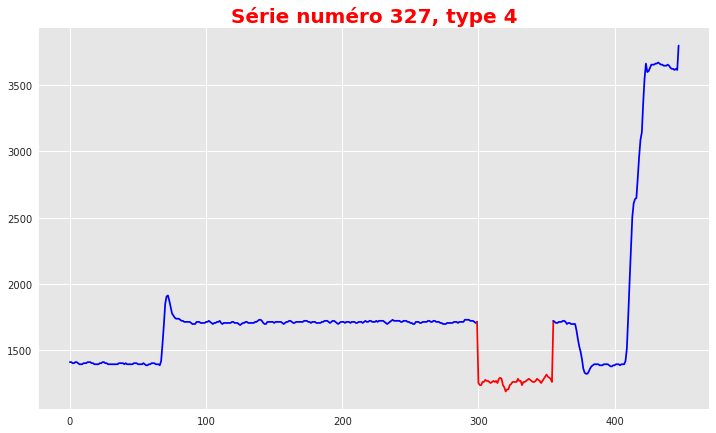

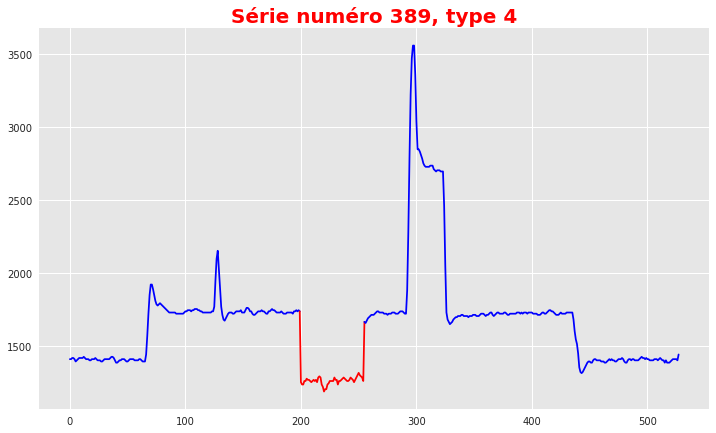

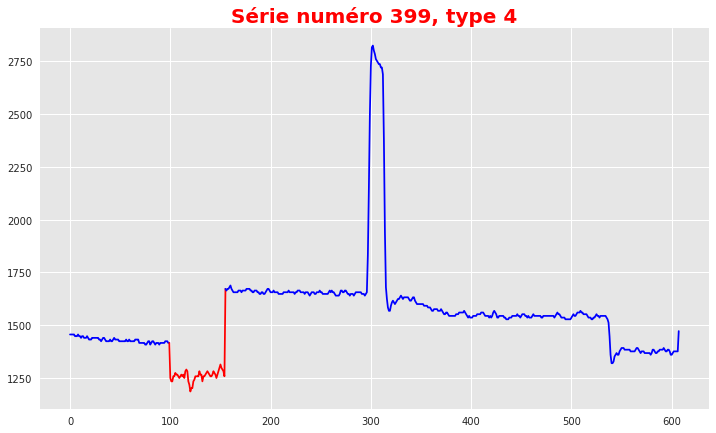

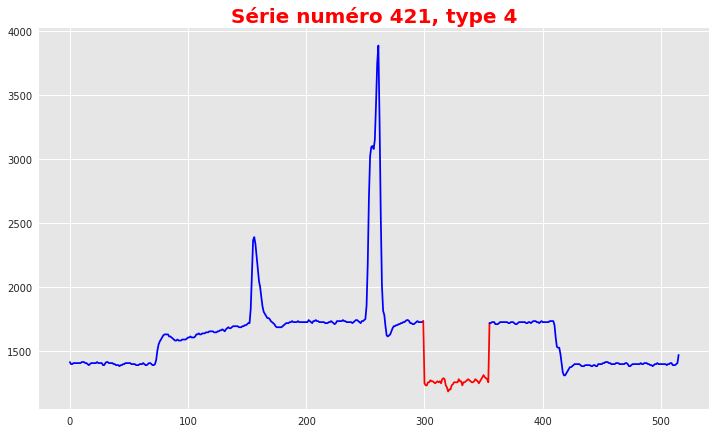

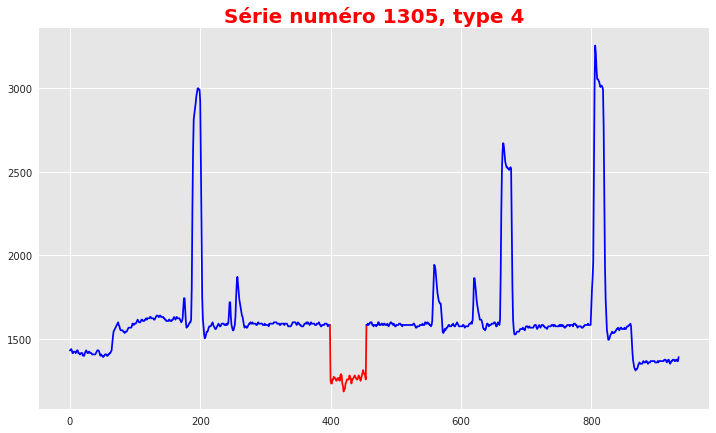

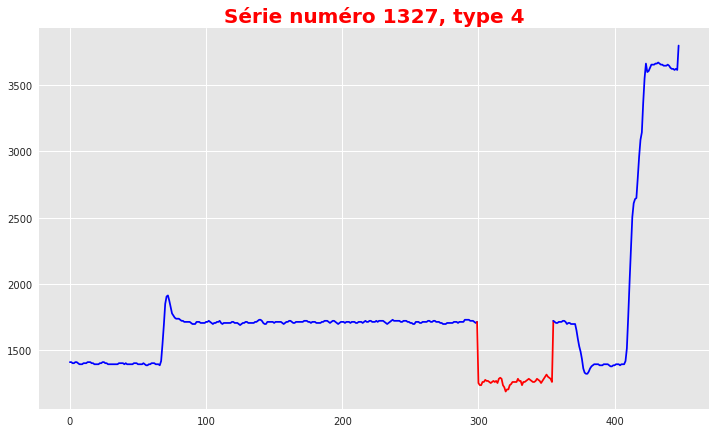

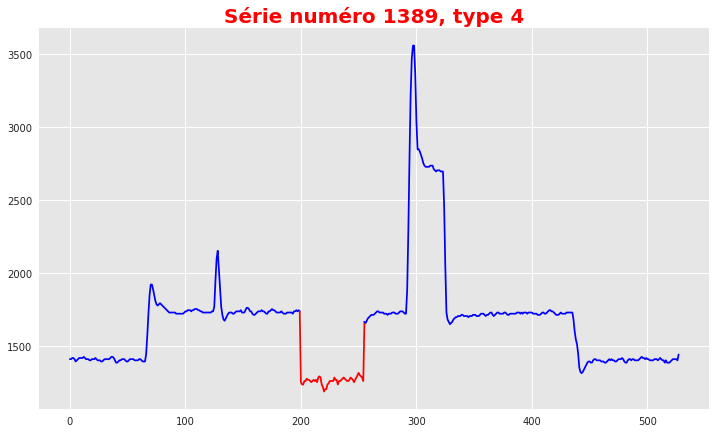

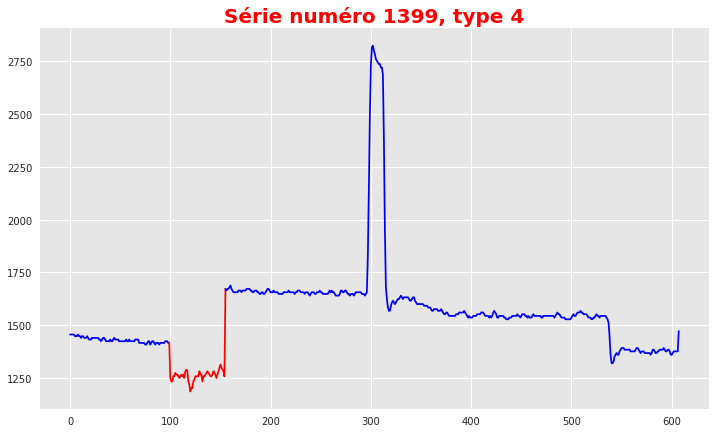

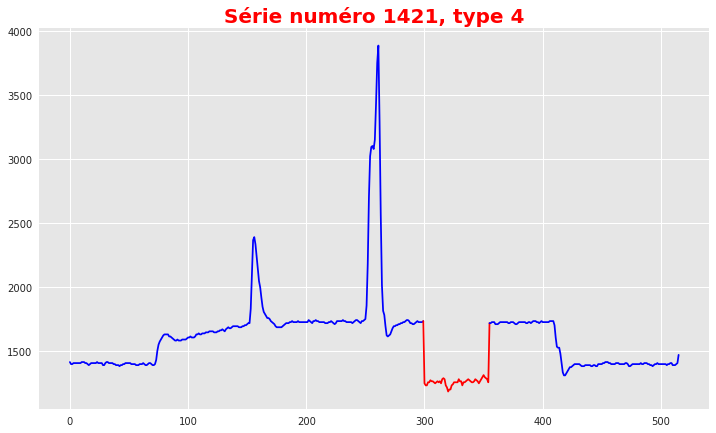

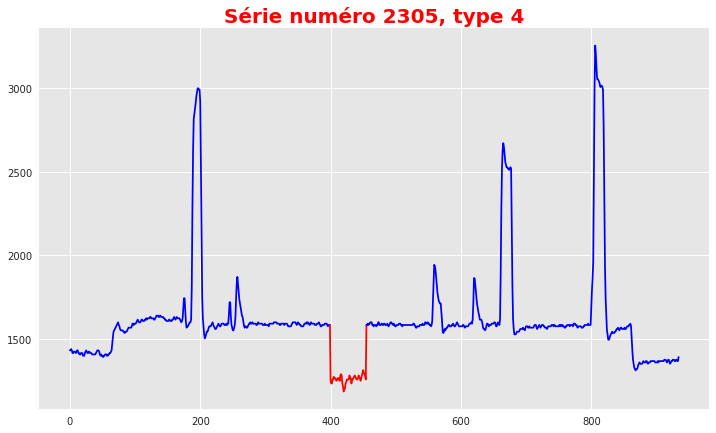

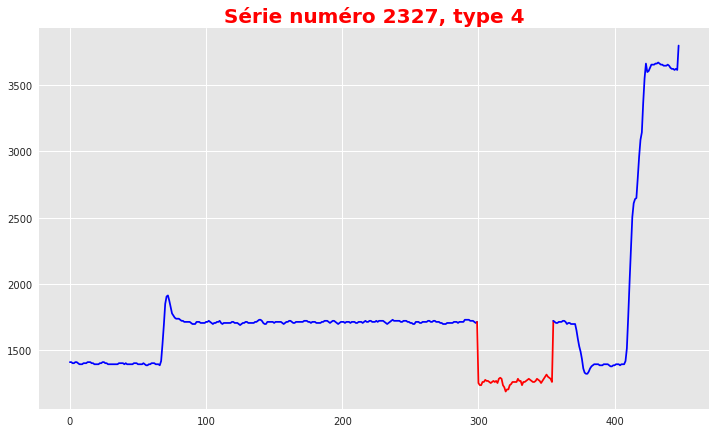

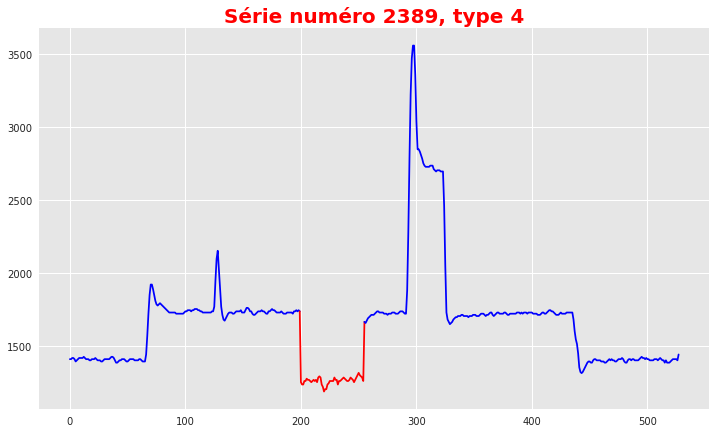

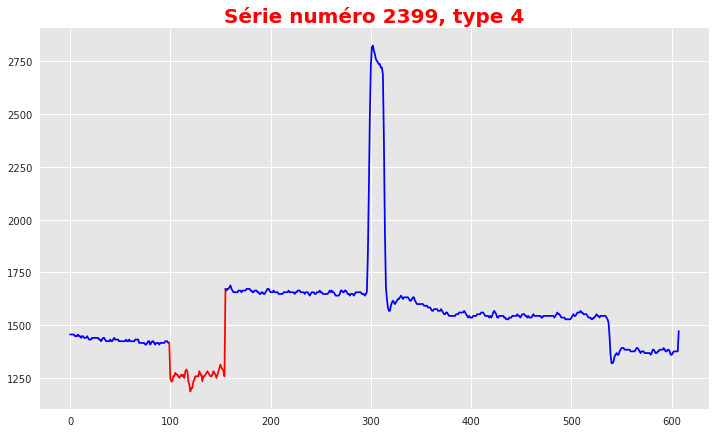

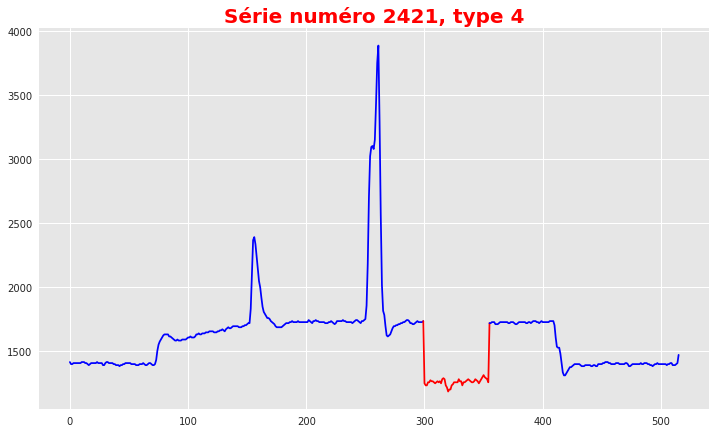

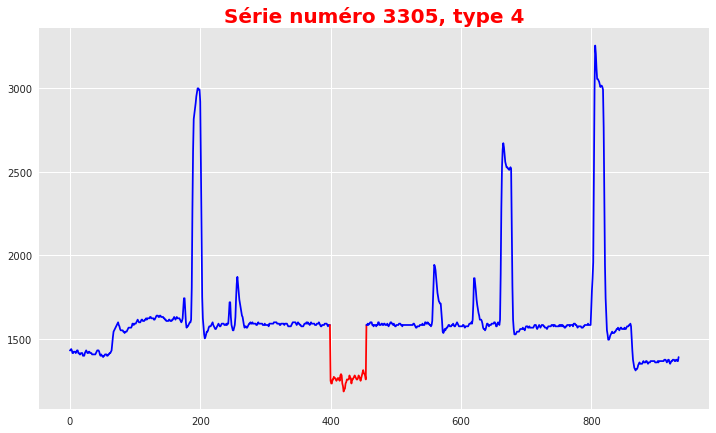

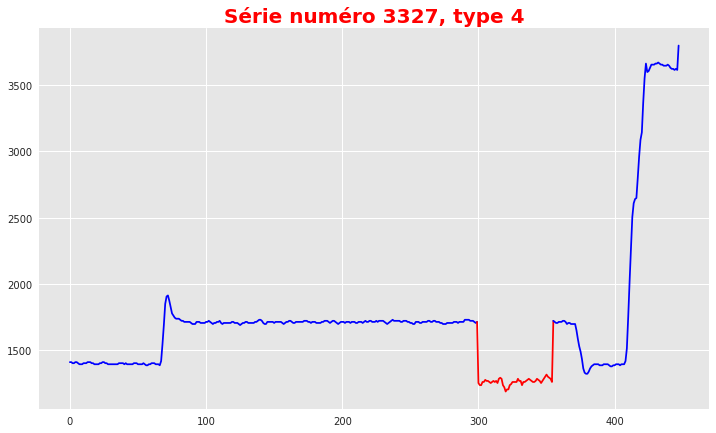

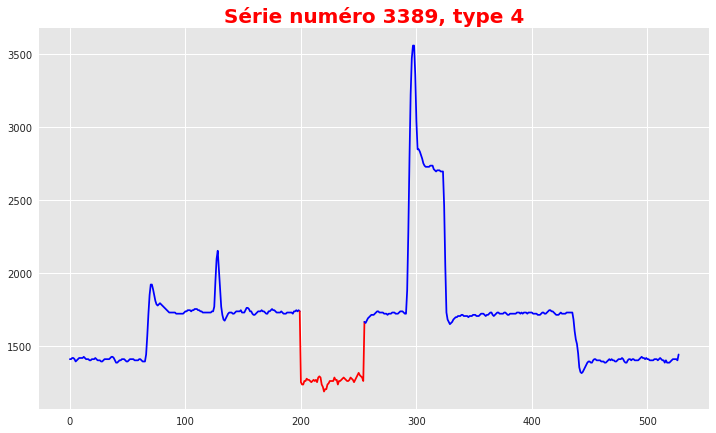

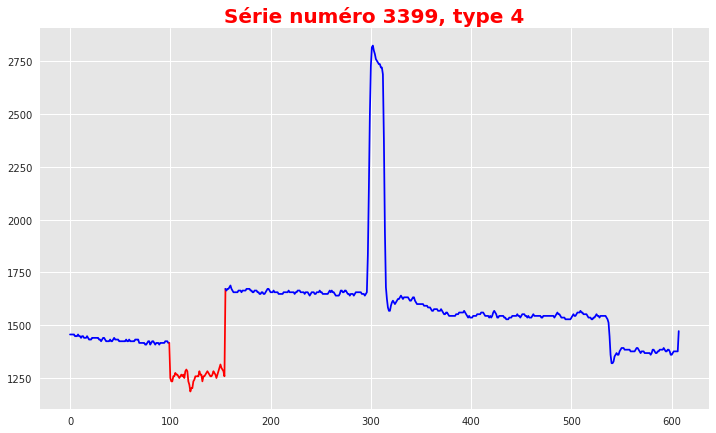

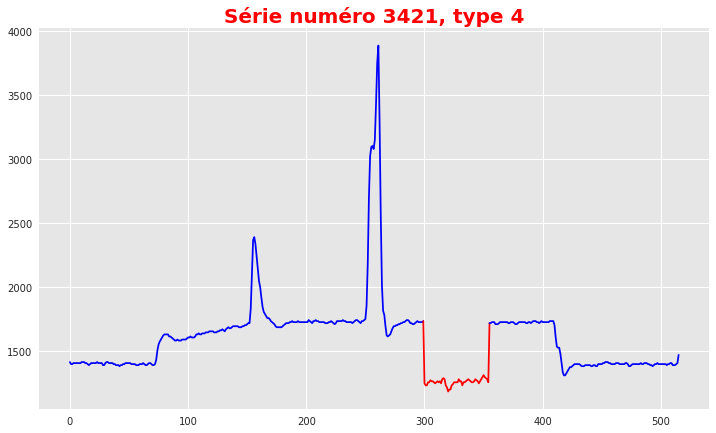

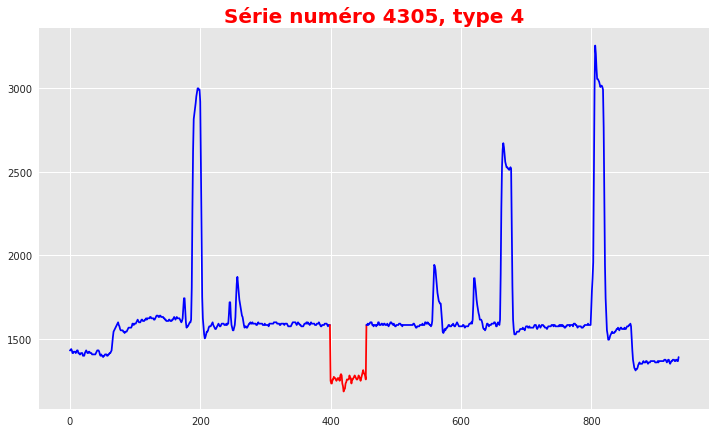

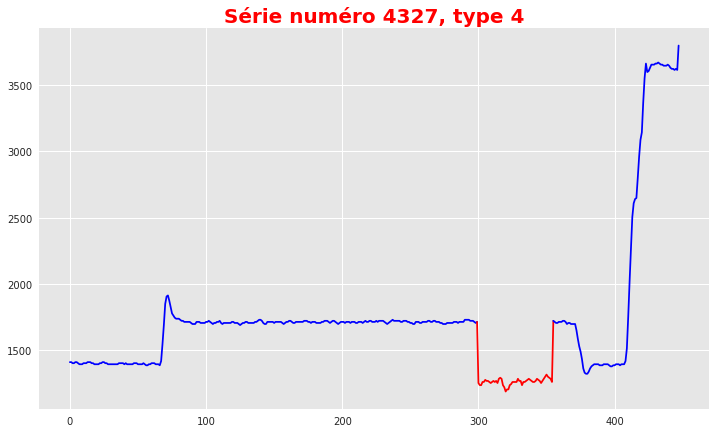

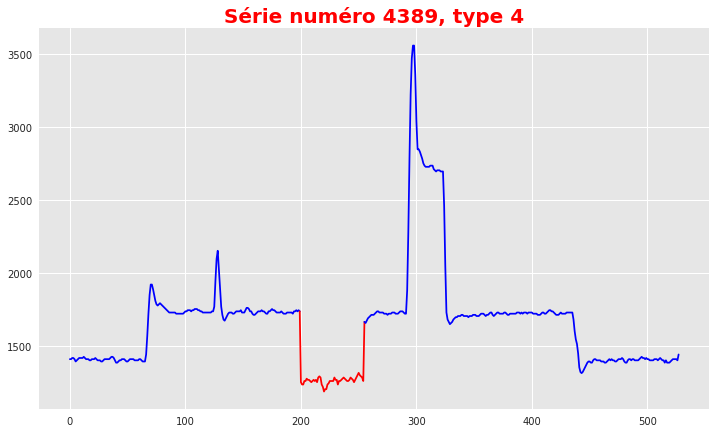

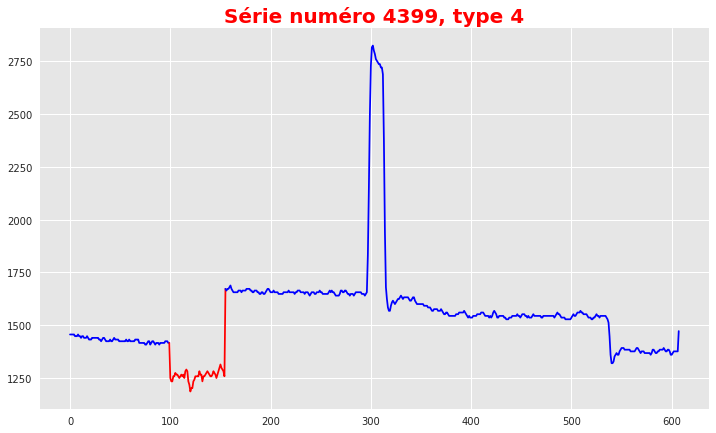

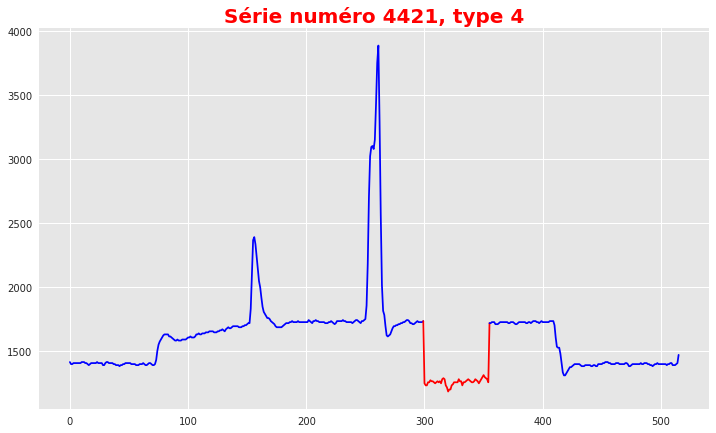

In [34]:
for T in range(1, 5):
    plot_anom_type(T)

## 3 - Méthodes de Classification

## Random Forest

In [37]:
from sklearn.model_selection import train_test_split  
X_train, X_test, Yb_train, Yb_test = train_test_split(df_supervise["valeurs"], df_supervise["anom"], test_size=100)

In [41]:
print(X_train)

id
421     [1416.0, 1400.0, 1400.0, 1408.0, 1408.0, 1408....
90      [1432.0, 1440.0, 1448.0, 1448.0, 1448.0, 1440....
290     [1384.0, 1384.0, 1384.0, 1384.0, 1392.0, 1392....
133     [1432.0, 1440.0, 1440.0, 1440.0, 1440.0, 1440....
114     [1408.0, 1400.0, 1400.0, 1400.0, 1400.0, 1400....
226     [1432.0, 1440.0, 1432.0, 1432.0, 1424.0, 1432....
215     [1392.0, 1400.0, 1400.0, 1400.0, 1400.0, 1400....
285     [1392.0, 1384.0, 1376.0, 1384.0, 1384.0, 1392....
20      [1400.0, 1400.0, 1392.0, 1400.0, 1400.0, 1400....
2396    [1400.0, 1400.0, 1408.0, 1408.0, 1424.0, 1424....
103     [1408.0, 1408.0, 1416.0, 1416.0, 1416.0, 1416....
4396    [1400.0, 1400.0, 1408.0, 1408.0, 1424.0, 1424....
5       [1400.0, 1392.0, 1392.0, 1392.0, 1400.0, 1400....
4421    [1416.0, 1400.0, 1400.0, 1408.0, 1408.0, 1408....
70      [1408.0, 1408.0, 1408.0, 1400.0, 1400.0, 1400....
4399    [1456.0, 1456.0, 1456.0, 1456.0, 1456.0, 1448....
390     [1432.0, 1432.0, 1432.0, 1440.0, 1440.0, 1440....
269     [13

In [40]:
from sklearn.preprocessing import StandardScaler  
# L'algorithme ds réseaux de neurones nécessite éventuellement une normalisation 
# des variables explicatives avec les commandes ci-dessous
scaler = StandardScaler()  
scaler.fit(X_train)  
Xr_train = scaler.transform(X_train)  
# Meme transformation sur le test
Xr_test = scaler.transform(X_test)

ValueError: setting an array element with a sequence.

In [39]:
from sklearn.ensemble import RandomForestClassifier 
# définition des paramètres
forest = RandomForestClassifier(n_estimators=500, criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1, max_features='auto', max_leaf_nodes=None, bootstrap=True, oob_score=True)
# apprentissage
rfFit = forest.fit(Xr_train,Yb_train)
print(1-rfFit.oob_score_)


ValueError: setting an array element with a sequence.